In [14]:
using DynamicalSystems, PyPlot

# DynamicalSystems.jl

**What is the package for?**

Define, integrate, and analyze dynamical systems. It comes with all kinds of (chaos) analysis tools, such as orbit diagrams, Poincare maps, Lyapunov exponents, and Renyi entropies.

---


Documentation: https://juliadynamics.github.io/DynamicalSystems.jl/latest/

The following is based on https://github.com/JuliaDynamics/Tutorials-and-Resources.

---

# What is a dynamical system?

A "dynamical system" is a law that describes how some variables should evolve in time. This law is described by the "equations of motion" function $\vec{f}$.

There are generally two types of dynamical systems:

1. One is called a map, where time is a discrete quantity (like "steps"). The equations of motion then look something like $\vec{u}_{n+1} = \vec{f}(\vec{u}_n, p, n)$ where $n$ is an integer and $p$ are the parameters of the system.

2. The other type is called an Ordinary Differential Equation (ODE), where time is a continuous quantity. Then, the equations of motion give the time derivatives of the variables: $\frac{d\vec{u}}{dt} = \vec{f}(\vec{u}, p, t)$.

In both cases $\vec{u}$ is the state of the system, a vector of the variables that define the system. For example, $\vec{u}$ may be defined as $(x, y, z)$, or as $(\theta, I)$, or as $(V, I, R, C_1, C_2)$, etc.

---

In Julia, for all intents and purposes, a `DynamicalSystem` is a `struct` that contains all the information of a dynamical system:

* Equations of motion function $\vec{f}$
* Initial state.
* Parameter container (if the equations of motion are parameterized).
* **Optional** : Jacobian of the equations of motion.

## First example: Lorenz system (continuous)

Equations of motion:
$$ {\begin{aligned}{\dot{x}}&=\sigma (y-x),\\{\dot{y}}&=x(\rho -z)-y,\\{\dot{z}}&=xy-\beta z.\end{aligned}} $$

In [41]:
# Manual implementation of EoM:
using StaticArrays
function lorenz_eom(u, p, t)
    σ = p[1]; ρ = p[2]; β = p[3]
    du1 = σ*(u[2]-u[1])
    du2 = u[1]*(ρ-u[3]) - u[2]
    du3 = u[1]*u[2] - β*u[3]
    return SVector{3}(du1, du2, du3)
end

# Define continuous dynamical system
u0=[0.0, 10.0, 0.0]; σ = 10.0; ρ = 28.0; β = 8/3;
lor = ContinuousDynamicalSystem(lorenz_eom, u0, [σ, ρ, β])

3-dimensional continuous dynamical system
 state:       [0.0, 10.0, 0.0]
 e.o.m.:      lorenz_eom
 in-place?    false
 jacobian:    ForwardDiff
 parameters:  [10.0, 28.0, 2.66667]

In [31]:
# However, a bunch of famous dynamical systems are already predefined
filter(x->!startswith(string(x), "#"), names(Systems, all=true))

49-element Array{Symbol,1}:
 :CoupledStandardMaps
 :Lorenz96           
 :Systems            
 :coupledstandardmaps
 :double_pendulum    
 :doublependulum_eom 
 :duffing            
 :duffing_eom        
 :duffing_jacob      
 :eom_towel          
 :eom_towel_iip      
 :eval               
 :gissinger          
 ⋮                   
 :rikitake_eom       
 :roessler           
 :roessler_eom       
 :roessler_jacob     
 :shinriki           
 :shinriki_eom       
 :shinriki_voltage   
 :standardmap        
 :standardmap_eom    
 :standardmap_jacob  
 :towel              
 :twopi              

In [43]:
lor = Systems.lorenz()

3-dimensional continuous dynamical system
 state:       [0.0, 10.0, 0.0]
 e.o.m.:      loop
 in-place?    false
 jacobian:    loop_jac
 parameters:  [10.0, 28.0, 2.66667]

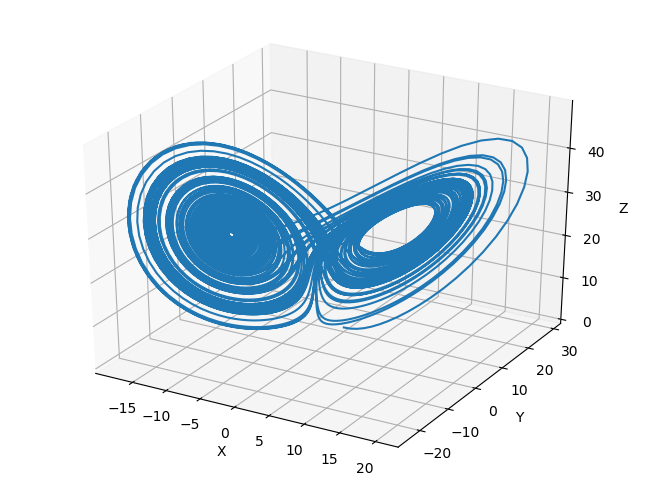

In [44]:
tr = trajectory(lor, 100.0, dt = 0.01)
figure(figsize = (8,6))
plot3D(columns(tr)...);
xlabel("X"); ylabel("Y"); zlabel("Z");

This is the famous [Lorenz butterfly](https://en.wikipedia.org/wiki/Butterfly_effect)!

## Poincare Surface of Section

### What ist it?

It's a technique to reduce a continuous system into a discrete map with 1 fewer dimension.
The wikipedia entry on [Poincaré map](https://en.wikipedia.org/wiki/Poincar%C3%A9_map) has a lot of useful info, but the technique itself is very simple:

1. Define a hyperplane in the phase-space of the system. 
2. Evolve the continuous system for long times. Each time the trajectory crosses this plane, record the state of the system.
3. Only crossings with a specific `direction` (either positive or negative) are allowed.

And that's it! The recorded crossings are the Poincare Surface of Section. (It can be viewed as a map: last intersection -> next intersection)

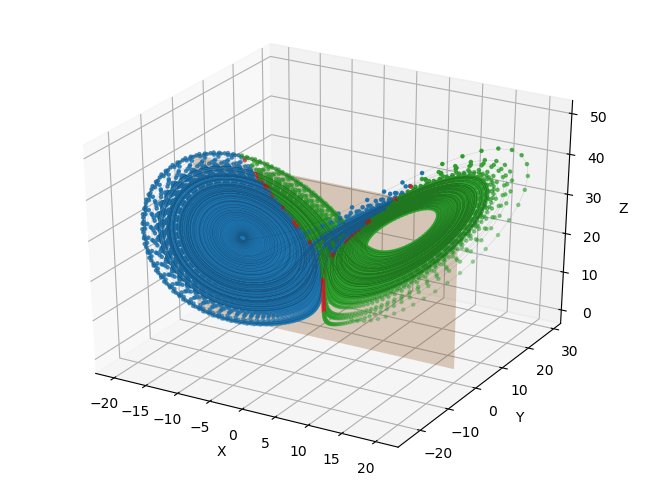

In [49]:
"""
    meshgrid(x, y) -> X, Y
Create a meshgrid, such as that used in PyPlot's countour plots.
"""
function meshgrid(vx, vy)
    m, n = length(vy), length(vx)
    vx = reshape(vx, 1, n)
    vy = reshape(vy, m, 1)
    (repeat(vx, m, 1), repeat(vy, 1, n))
end

tr = trajectory(lor, 200.0, dt=0.01)
x, y, z = columns(tr);

c = Vector{String}(undef, length(y))
for i in 1:length(y) # cut points: red
    if -0.1 < y[i] < 0.1
        c[i] = "C3"
    elseif y[i] < 0 
        c[i] = "C0" # in front of cut: blue
    else
        c[i] = "C2" # behind cut: green
    end
end

figure(figsize = (8,6))
# First let's plot the attractor
plot3D(x,y,z, color = "black", lw = 0.2, alpha = 0.25)
scatter3D(x, y, z, color = c, s = 5.0)

# And then plot the PSOS plane:
x = [-20, 20]; z = [0, 40]; 
X, Z = meshgrid(x, z)
Y = zero(X)

plot_surface(X, Y, Z, alpha = 0.25, color = "C1");
xlabel("X"); ylabel("Y"); zlabel("Z");

### `poincaresos`

Let's say that our phase-space is $D$ dimensional. If the state of the system is $\mathbf{u} = (u_1, \ldots, u_D)$ then the equation for a hyperplane is 

$$
a_1u_1 + \dots + a_Du_D = \mathbf{a}\cdot\mathbf{u}=b 
$$
where $\mathbf{a}, b$ are the parameters that define the hyperplane.

---

Here is the call signature for a function that does this:

```julia
poincaresos(continuous_system, plane, tfinal = 100.0; direction = 1, ...)
```
In code, `plane` can be either:

* A `Tuple{Int, <: Number}`, like `(j, r)` : the hyperplane is defined as when the `j` variable of the system crosses the value `r`.
* An `AbstractVector` of length `D+1`. The first `D` elements of the vector correspond to $\mathbf{a}$ while the last element is $b$. The hyperplane is defined with its formal equation.

In [61]:
psos = poincaresos(lor, (2, 0.0), 2000.0) # find where 2nd variable crosses 0.0

# returns (x,y,z) coordinates of all red points above
psos

3-dimensional Dataset{Float64} with 980 points
 15.8199    1.85511e-6   48.2703
 10.8266    1.06123e-6   39.3078
 -1.63597  -3.04791e-7   22.7495
  8.83098   1.60861e-5   35.9395
  8.44242   9.10631e-6   35.2912
  6.06326   3.44576e-5   31.3219
  9.85274   8.00996e-7   37.6549
 -1.36409   1.40472e-8   21.9828
  7.62944   1.20223e-5   33.937 
  4.25046   6.48571e-8   28.1932
  8.92966   8.36877e-7   36.1046
  8.9131    1.96114e-5   36.0771
  8.83539   4.21952e-6   35.9472
  ⋮                             
 10.4376    3.87639e-8   38.6452
 10.7528    1.19554e-6   39.1817
 -1.14897   8.00792e-10  21.307 
  6.35592   4.18924e-5   31.8127
 10.1861    6.93591e-7   38.2183
 -3.25509  -3.20214e-5   26.3453
  8.56455   1.44466e-6   35.4949
  6.99648   1.80374e-5   32.8837
 11.2554    4.53577e-7   40.0422
 11.963     1.81959e-7   41.2649
 -1.69069  -5.54491e-8   22.8946
  4.87296   0.000172906  29.2906


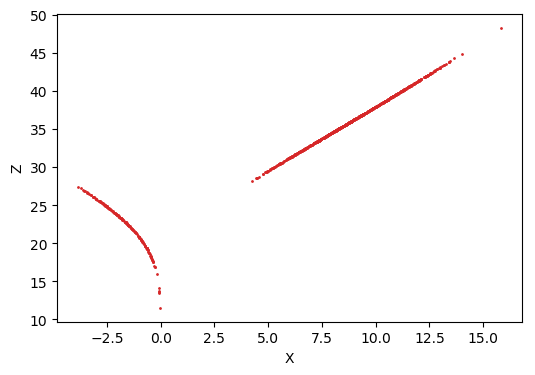

In [64]:
figure(figsize = (6,4))
plot(psos[:, 1], psos[:, 3], lw=0.0, marker ="o", ms = 1.0, color = "C3");
xlabel("X"); ylabel("Z");

* We see that the surface of section is some kind of 1-dimensional object.
* It is extended which is (might be) an indication of chaos.
* This is reasonable, as the attractor is quasi two dimensional. When you take a cut through this object, the result should be 1-dimensional.

# Second example: Logistic map (discrete)

Equation of evolution:
$$ x_{n+1} = rx_n(1-x_n) $$

In [65]:
# Manual way:
logistic_eom(x, p, n) = p[1]*x*(1-x)

x0 = rand(); r = 4.0;
logimap = DiscreteDynamicalSystem(logistic_eom, x0, [r])

# Or predefined:
logimap = Systems.logistic()

1-dimensional discrete dynamical system
 state:       0.40456986682109464
 e.o.m.:      logistic_eom
 in-place?    false
 jacobian:    logistic_jacob
 parameters:  [4.0]

### Orbit diagram

The call signature of `orbitdiagram` is:

```julia
orbitdiagram(discrete_system, i, p_index, pvalues; n, Ttr, ...)
```
* `i` is the index of the variable we want to save.
* `p_index` is the index of the parameter we want to change.
* `pvalues` are the values of the parameter that will change.
* Keywords `Ttr` and `n` denote for how much transient time to evolve the system and how many states to save.


In [77]:
i = 1 # which variable to save (of course logistic map is 1D !)
n = 200 # how many values to save
Ttr = 2000 # transient iterations
p_index = 1
pvalues = range(2.0, stop=4.0, length=1000)  # parameter values
output = orbitdiagram(logimap, i, p_index, pvalues; n = n, Ttr = Ttr)
typeof(output)

Array{Array{Float64,1},1}

* The output is a vector of vectors. Each inner vector has length `n` and contains the values of the variable `i` at the given parameter value.

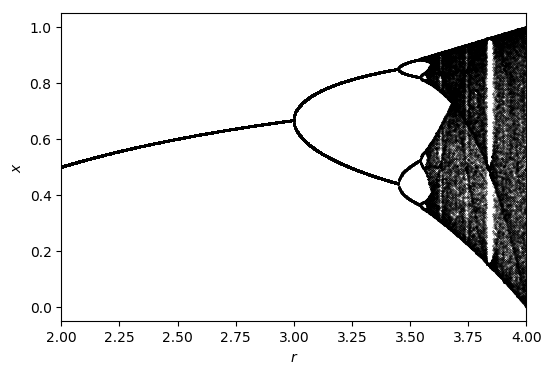

(2.0, 4.0)

In [78]:
# Plot it!
figure(figsize=(6,4))
for (j, p) in enumerate(pvalues)
    plot(p .* fill(1., size(output[j])), output[j], linestyle = "None", # linestyle = None
    marker = "o", ms = 0.2, color = "black")
end
xlabel("\$r\$"); ylabel("\$x\$");
xlim(pvalues[1], pvalues[end])

That's the famous [bifurcation diagram](https://en.wikipedia.org/wiki/Bifurcation_diagram)!

Let's look closer at the `r ∈ [3.5, 3.6]` interval:

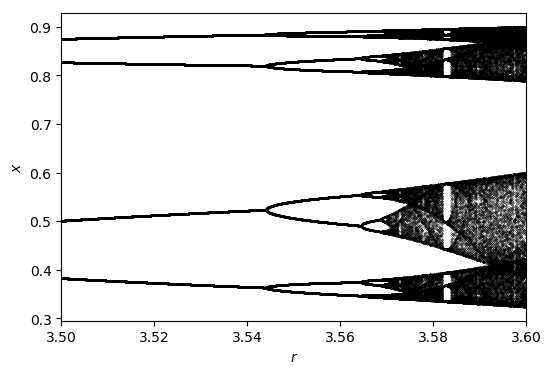

(3.5, 3.6)

In [82]:
pvalues = range(3.5, stop=3.6, length=1000)
output = orbitdiagram(logimap, i, p_index, pvalues; n = n, Ttr = Ttr)
figure(figsize=(6,4))
for (j, p) in enumerate(pvalues)
    plot(p .* fill(1., size(output[j])), output[j], linestyle = "None", # linestyle = None
    marker = "o", ms = 0.2, color = "black")
end
xlabel("\$r\$"); ylabel("\$x\$");
xlim(pvalues[1], pvalues[end])

** It is self similar! **

### Renyi entropy

Basically extension of http://juliastats.github.io/StatsBase.jl/stable/scalarstats.html#StatsBase.renyientropy to trajectories.

In [132]:
tr = trajectory(Systems.logistic(; r=2.0), 10000.0)

genentropy(1, 0.01, tr) # first argument is α of Renyi entropy. For α=1 it is the Shannon entropy

0.003062780832009578

Compare to randomness

In [133]:
genentropy(1, 0.01, rand(length(tr)))

4.600548964709951

As expected, the entropy is larger for the random trajectory.